Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения. 

Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную.

# Импорт библиотек

In [ ]:
from google.colab import files, drive
from tensorflow.keras.utils import to_categorical
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Подключение к Диску и импорт данных

In [ ]:
drive.mount('/content/drive')
!unzip -q '/content/drive/MyDrive/Lessons/Lesson8/genres.zip'
genres = os.listdir('genres')
!ls genres 
!ls genres/blues

Mounted at /content/drive
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
bl

# Функции для работы с аудиозаписями

In [ ]:
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  rmse = np.mean(librosa.feature.rms(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  for e in mfcc:
    out.append(np.mean(e))

  for e in chroma_stft:
    out.append(np.mean(e))
  
  return out

 # Подготовка данных для обучения

In [ ]:
import time

X_train = []
Y_train = []

curr_time = time.time()

for i in range(len(genres)):
  g = genres[i]
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    
    X_train.append(out)
    Y_train.append(to_categorical(i, len(genres)))

  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр reggae готов -> 41c
Жанр classical готов -> 40c
Жанр pop готов -> 41c
Жанр disco готов -> 40c
Жанр rock готов -> 45c
Жанр country готов -> 40c
Жанр hiphop готов -> 40c
Жанр blues готов -> 40c
Жанр metal готов -> 41c
Жанр jazz готов -> 41c


In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


## Стандартизация

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
print(X_train[0])

[-0.55960858 -0.09571515  0.08998277  0.14616457 -0.13934326 -0.14946545
  0.1690017  -0.06359683 -0.09791871 -0.31264414  1.0290304  -1.6927089
  1.27523903 -0.84894984  1.49476875 -0.33503813  0.78050163 -0.85526472
 -0.07246325 -0.54079374 -0.01601026 -1.15312062  0.71772301  0.41645312
  1.26663375 -1.16926596  0.74634203 -0.54389387 -1.05207334  0.20502084
 -0.04367669  0.53005382 -1.05687871 -0.65357906 -0.12634906 -0.950966
 -1.06921134]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


# Подготовка и обучение модели

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


45/45 [==============================] - 2s 8ms/step - loss: 2.1296 - accuracy: 0.2222 - val_loss: 1.9808 - val_accuracy: 0.2900
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 1.7619 - accuracy: 0.3433 - val_loss: 1.7661 - val_accuracy: 0.3000
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 1.6855 - accuracy: 0.3767 - val_loss: 1.6900 - val_accuracy: 0.2900
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 1.5894 - accuracy: 0.4167 - val_loss: 1.5911 - val_accuracy: 0.3400
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 1.5175 - accuracy: 0.4344 - val_loss: 1.5628 - val_accuracy: 0.3500
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 1.5110 - accuracy: 0.4278 - val_loss: 1.4745 - val_accuracy: 0.3900
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 1.4305 - accuracy: 0.4578 - val_loss: 1.4324 - val_accuracy: 0.4800
Epoch 8/100
45/45 [======

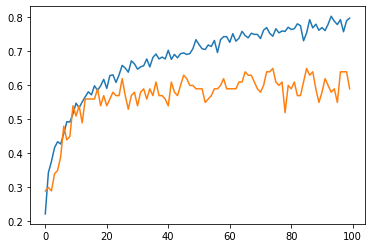

In [ ]:
indexes = range(0,37)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(indexes),)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(132, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(132, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()